# Question 2

In [55]:
#imports
library(readr)
library(tigerstats)
library(ggplot2)
library(gridExtra)
library("DESeq2")
library("vsn")
library("pheatmap")
library("RColorBrewer")
library(repr)

In [56]:
#load data
cd <- read_tsv("clinical-data.tsv") 
mc <- read_tsv("morphological-counts.tsv")


Rows: 136 Columns: 12
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr (5): SMPLID, SMPTHNTS, COHORT, SUBJID, IMGURL
dbl (7): SEX, AGE, HGHT, WGHT, BMI, TRISCHD, DTHHRDY

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 136 Columns: 65
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: "\t"
chr  (1): SMPLID
dbl (64): Mophological.cluster.0, Mophological.cluster.1, Mophological.clust...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [57]:
#normalisation pour les variables numériques et changement de type pour les variable catégorielles 
numerical_variables <- list('AGE', 'HGHT', 'WGHT', 'BMI', 'TRISCHD') 
categorical_variables <- list('SEX', 'COHORT', 'DTHHRDY')
for (variable in numerical_variables){
    cd[variable] <- scale(cd[variable])
}
for (variable in categorical_variables){
    cd[variable] <- factor(cd[[variable]])
}

In [59]:
mc

SMPLID,Mophological.cluster.0,Mophological.cluster.1,Mophological.cluster.2,Mophological.cluster.3,Mophological.cluster.4,Mophological.cluster.5,Mophological.cluster.6,Mophological.cluster.7,Mophological.cluster.8,...,Mophological.cluster.54,Mophological.cluster.55,Mophological.cluster.56,Mophological.cluster.57,Mophological.cluster.58,Mophological.cluster.59,Mophological.cluster.60,Mophological.cluster.61,Mophological.cluster.62,Mophological.cluster.63
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GTEX-11EM3-0126,20,22,107,74,49,589,466,88,49,...,99,41,150,18,2,2,193,44,66,24
GTEX-11EQ9-0626,51,81,87,87,64,377,256,74,33,...,223,58,55,25,5,0,127,25,17,42
GTEX-11LCK-0526,79,86,51,87,16,169,310,153,97,...,316,166,74,31,71,36,99,173,173,15
GTEX-11NSD-0126,45,140,34,51,29,455,281,43,60,...,66,31,25,36,8,78,88,40,73,34
GTEX-11O72-2326,171,139,44,133,95,61,260,12,16,...,28,120,62,340,41,16,31,18,62,643
GTEX-11P7K-0226,159,65,31,53,12,491,674,18,122,...,6,139,17,37,28,78,91,79,387,76
GTEX-11P81-0126,86,189,40,52,10,53,141,27,24,...,55,103,28,38,50,0,15,29,25,62
GTEX-11P82-0226,71,122,13,7,12,303,285,6,86,...,52,102,21,18,65,31,78,342,302,26
GTEX-11TT1-1126,30,100,323,48,146,724,114,14,263,...,140,115,113,65,1,0,208,25,28,23


## Pré-analyses

### Corrélation moyenne-variance

In [ ]:
#Dans l'article sur DESseq2 ils parlent du fait qu'avec les rna counts on a une corrélation entre la moyenne de l'expression
#d'un gêne et sa variance, et du coup il vaut mieux faire une normalisation, par exemple pour les pca etc. du coup je voulais
#vérifier si c'est le cas aussi avec les cluster counts mais il semble que non
#après, ça ne veut pas nécessairement dire qu'il ne faut pas quand même faire de normalisation 

means <- colMeans(mc_red)
sdev <- sapply(mc_red, sd)

plot(means, sdev)
cor(means, sdev)

In [ ]:
meanSdPlot(t(data.matrix(mc_red)), ranks=FALSE)

In [ ]:
#par comparaison, faisons la même chose avec les rna counts
rna =  read_tsv("RNA-read-counts.tsv")
rna
meanSdPlot(t(data.matrix(rna)), ranks=FALSE)


In [ ]:
mrna <- rna[,3:65]
means <- colMeans(mrna)
sdev <- sapply(mrna, sd)

plot(means, sdev)
cor(means, sdev)

#on voit que la corrélation est beaucoup plus élevée

### Création de l'objet DESeqDataSet

In [ ]:
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ AGE)


### Sample distances

In [60]:
#pas encore sur de quoi faire avec ça mais je me disais qu'on pourrait peut-être faire quelque chose avec une matrice
#des distances entre samples
sampleDists <- dist(t(assay(dds)))
sampleDists

            1         2         3         4         5         6         7
2    691.9588                                                            
3   1050.6912  858.8160                                                  
4    830.6269  493.9109  792.7616                                        
5   1442.0669 1308.5748 1161.6725 1278.9636                              
6    934.8765 1052.6885 1018.1532  883.1506 1526.9319                    
7   1430.2311  991.9365 1048.4918  935.6132 1333.5419 1441.3851          
8   1354.9240 1197.7045 1002.3068  925.0611 1571.2218 1068.6473 1293.6808
9   1511.3431 1700.2585 2087.6652 1881.4853 2368.3460 1824.7016 2312.4439
10  1258.8685 1105.8458 1045.5362  970.6807 1514.6594 1118.5178 1352.3006
11  1889.6383 1624.4858 1892.2846 1674.0048 1984.4349 2051.3393 1802.1121
12  1320.2011 1068.9228  876.7799  916.0448 1162.5627 1040.1360 1088.4889
13  1969.2907 1731.0081 1669.0992 1683.5757 1221.7934 1939.3184 1697.5574
14  1244.9297  773.8249  877.7551  701

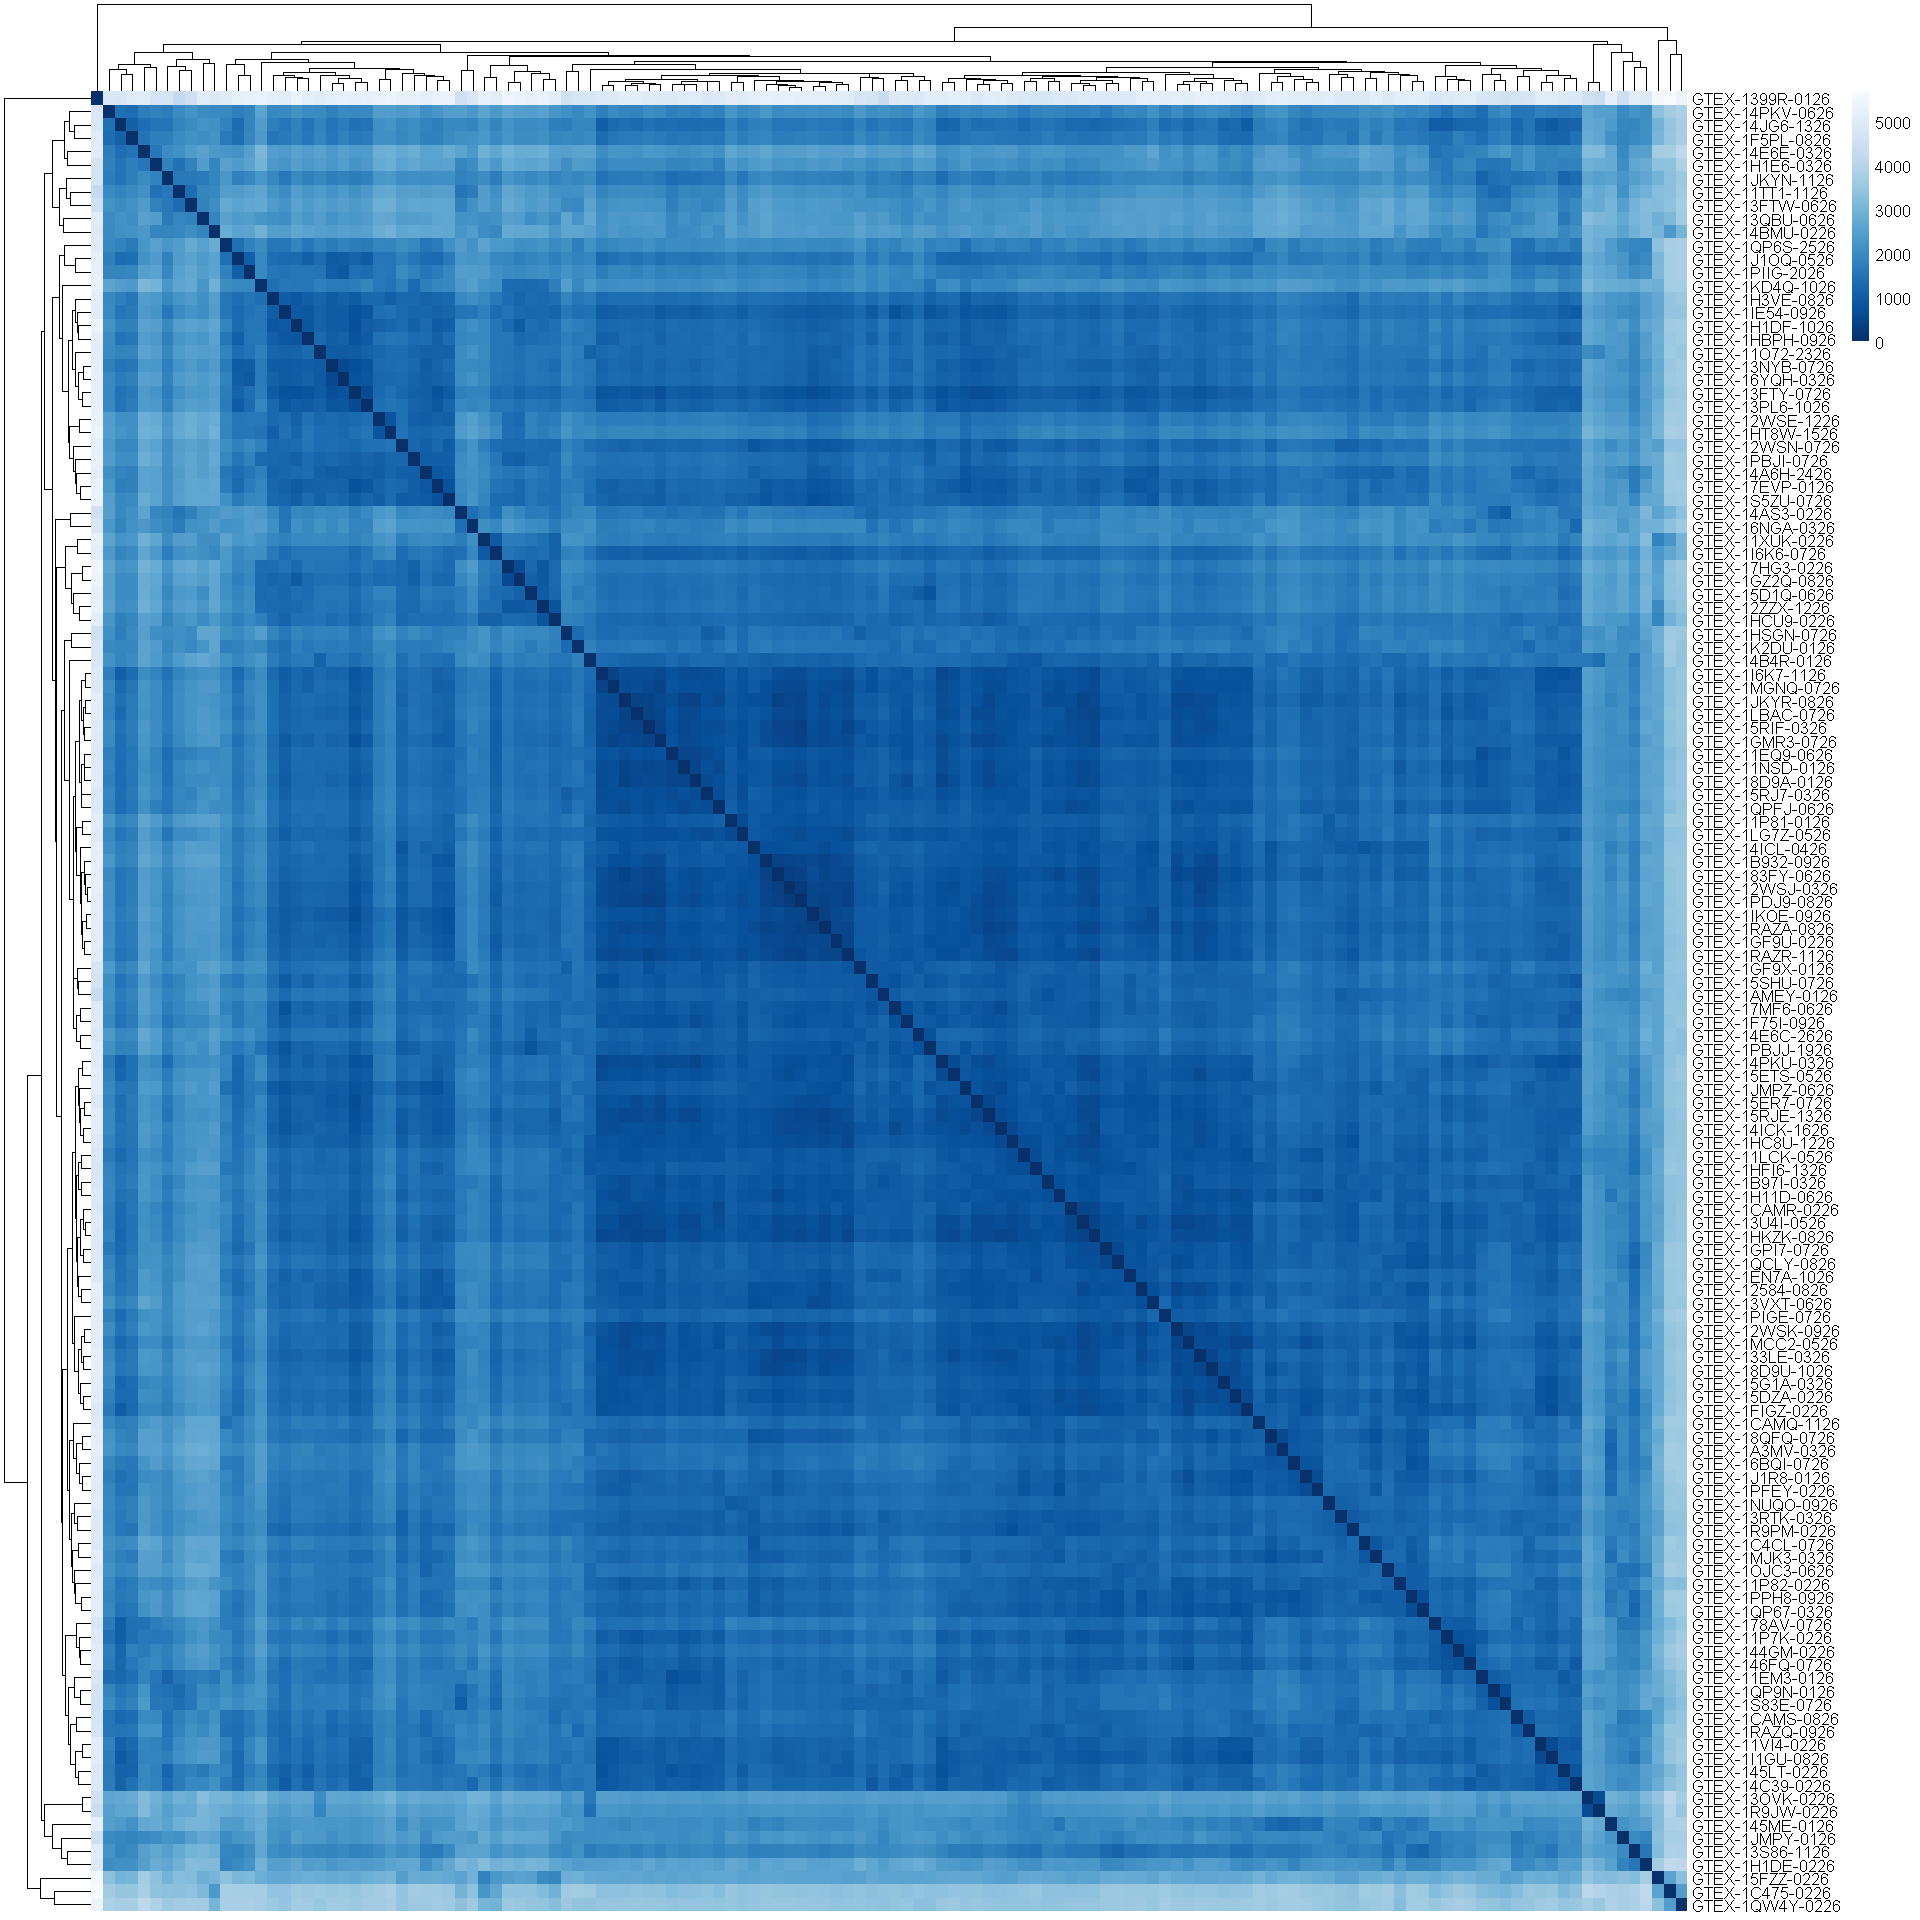

In [61]:
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( cd$SMPLID )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
options(repr.plot.width=16, repr.plot.height=16)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

### Corrélations des clusters morphologiques entre eux

In [62]:
corr <- cor(st_mc)
corr <- abs(corr)
corr[corr==1.0]<-0.0
max(corr)
#j'ai pas été loin dans l'analyse de la matrice de corrélation pour l'instant, mais avec une corrélation max de 0.88 on 
#pourrait éventuellement envisager d'éliminer les clusters les plus corrélés

ERROR: Error in h(simpleError(msg, call)): erreur d'ï¿½valuation de l'argument 'x' lors de la sï¿½lection d'une mï¿½thode pour la fonction 'cor' : objet 'st_mc' introuvable


### PCA des clusters

In [ ]:
pca = prcomp(st_mc)
colors <- rep("black", 136)
colors[cd$SEX == 1] <- "red"
plot(pca$x[, 1:2], col=colors)

## Analyse de l'expression différentielle

In [4]:
#assoc_table va être une matrice ou on voit pour chaque variable quel cluster est différentiellement exprimé
row <- colnames(cd)[2:10]
row <- row[-6]

col <- colnames(mc[,2:65])
assoc_table <- data.frame(matrix(ncol = 64, nrow = 8))
colnames(assoc_table) <- col
rownames(assoc_table) <- row
assoc_table[,] <- FALSE
assoc_table

,Mophological.cluster.0,Mophological.cluster.1,Mophological.cluster.2,Mophological.cluster.3,Mophological.cluster.4,Mophological.cluster.5,Mophological.cluster.6,Mophological.cluster.7,Mophological.cluster.8,Mophological.cluster.9,...,Mophological.cluster.54,Mophological.cluster.55,Mophological.cluster.56,Mophological.cluster.57,Mophological.cluster.58,Mophological.cluster.59,Mophological.cluster.60,Mophological.cluster.61,Mophological.cluster.62,Mophological.cluster.63
,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,...,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
SEX,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
AGE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
HGHT,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WGHT,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
BMI,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
COHORT,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TRISCHD,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
DTHHRDY,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


#### Sex

In [63]:
dsd = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ SEX)


converting counts to integer mode



In [65]:
# calcul des expressions différentielles
dds <- DESeq(dds)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 10 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [66]:
res <- results(dds)
resultsNames(dds)
res
summary(res)

[1] "Intercept"  "SEX_2_vs_1"

log2 fold change (MLE): SEX 2 vs 1 
Wald test p-value: SEX 2 vs 1 
DataFrame with 65 rows and 6 columns
                         baseMean log2FoldChange     lfcSE      stat    pvalue
                        <numeric>      <numeric> <numeric> <numeric> <numeric>
SMPLID                    72.9315       0.194895  0.214459  0.908774 0.3634695
Mophological.cluster.0   105.4915       0.393762  0.194342  2.026128 0.0427517
Mophological.cluster.1   103.7647       0.186658  0.230576  0.809531 0.4182099
Mophological.cluster.2   117.1776       0.169954  0.244563  0.694930 0.4870990
Mophological.cluster.3   125.2827       0.494131  0.226603  2.180604 0.0292128
...                           ...            ...       ...       ...       ...
Mophological.cluster.59   13.8445      0.2001548  0.408155  0.490390 0.6238581
Mophological.cluster.60  126.7505      0.3583921  0.194006  1.847321 0.0647006
Mophological.cluster.61  139.2785     -0.1050435  0.275162 -0.381752 0.7026454
Mophological.cluster.62  15


out of 65 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 14, 22%
LFC < 0 (down)     : 1, 1.5%
outliers [1]       : 0, 0%
low counts [2]     : 2, 3.1%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [67]:
#pour voir le nombre de clusters pour lesquels la p-value est inférieure à 0.05
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)


FALSE  TRUE 
   58     7 

In [68]:
#Voir les 7 clusters avec la p-value ajustée en dessous de 0.05
resSig <- subset(res, padj < 0.05)
resSig[ order(resSig$log2FoldChange), ]


log2 fold change (MLE): SEX 2 vs 1 
Wald test p-value: SEX 2 vs 1 
DataFrame with 7 rows and 6 columns
                         baseMean log2FoldChange     lfcSE      stat
                        <numeric>      <numeric> <numeric> <numeric>
Mophological.cluster.28  154.2311       0.611144  0.215170   2.84029
Mophological.cluster.29   71.3152       0.672496  0.225778   2.97857
Mophological.cluster.57  114.7111       0.944129  0.282605   3.34081
Mophological.cluster.18   79.0266       1.053218  0.268311   3.92536
Mophological.cluster.38   92.7315       1.073725  0.294151   3.65026
Mophological.cluster.42  108.5923       1.816409  0.393394   4.61728
Mophological.cluster.36  116.7020       2.803487  0.460505   6.08786
                             pvalue        padj
                          <numeric>   <numeric>
Mophological.cluster.28 4.50729e-03 4.05656e-02
Mophological.cluster.29 2.89601e-03 3.04081e-02
Mophological.cluster.57 8.35347e-04 1.05254e-02
Mophological.cluster.18 8.65987e-05 

In [69]:
#on remplit la colonne SEX dans assoc_table
assoc_table["SEX",] <- colnames(assoc_table) %in% rownames(resSig)
print(assoc_table['SEX',])

    Mophological.cluster.0 Mophological.cluster.1 Mophological.cluster.2
SEX                  FALSE                  FALSE                  FALSE
    Mophological.cluster.3 Mophological.cluster.4 Mophological.cluster.5
SEX                  FALSE                  FALSE                  FALSE
    Mophological.cluster.6 Mophological.cluster.7 Mophological.cluster.8
SEX                  FALSE                  FALSE                  FALSE
    Mophological.cluster.9 Mophological.cluster.10 Mophological.cluster.11
SEX                  FALSE                   FALSE                   FALSE
    Mophological.cluster.12 Mophological.cluster.13 Mophological.cluster.14
SEX                   FALSE                   FALSE                   FALSE
    Mophological.cluster.15 Mophological.cluster.16 Mophological.cluster.17
SEX                   FALSE                   FALSE                   FALSE
    Mophological.cluster.18 Mophological.cluster.19 Mophological.cluster.20
SEX                    TRUE     

### Numerical variables

In [70]:
#fonction pour remplir la ligne du tableau 'assoc_table' associée avec une variable clinique numérique
num_dif_exp <- function(condition, assoc_table){
    cond <- as.formula(paste("~", condition))
    print(cond)
    dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = cond)
    dds <- DESeq(dds, quiet=TRUE)
    res <- results(dds)
    res.05 <- results(dds, alpha = 0.05)
    resSig <- subset(res, padj < 0.05)
    print(rownames(resSig))
    assoc_table[condition,] <<- colnames(assoc_table) %in% rownames(resSig)
}

In [71]:
for(variable in numerical_variables){
    num_dif_exp(variable, assoc_table)}

~AGE
<environment: 0x000000000607f378>


converting counts to integer mode



 [1] "Mophological.cluster.1"  "Mophological.cluster.2" 
 [3] "Mophological.cluster.4"  "Mophological.cluster.6" 
 [5] "Mophological.cluster.7"  "Mophological.cluster.10"
 [7] "Mophological.cluster.18" "Mophological.cluster.19"
 [9] "Mophological.cluster.25" "Mophological.cluster.27"
[11] "Mophological.cluster.29" "Mophological.cluster.38"
[13] "Mophological.cluster.40" "Mophological.cluster.44"
[15] "Mophological.cluster.48" "Mophological.cluster.50"
[17] "Mophological.cluster.56" "Mophological.cluster.59"
[19] "Mophological.cluster.60"
~HGHT
<environment: 0x0000000009d91ed8>


converting counts to integer mode



 [1] "Mophological.cluster.4"  "Mophological.cluster.12"
 [3] "Mophological.cluster.14" "Mophological.cluster.18"
 [5] "Mophological.cluster.28" "Mophological.cluster.36"
 [7] "Mophological.cluster.42" "Mophological.cluster.45"
 [9] "Mophological.cluster.46" "Mophological.cluster.47"
[11] "Mophological.cluster.50"
~WGHT
<environment: 0x000000000ae50568>


converting counts to integer mode



[1] "Mophological.cluster.4"  "Mophological.cluster.14"
[3] "Mophological.cluster.15" "Mophological.cluster.35"
[5] "Mophological.cluster.46"
~BMI
<environment: 0x000000000ae8a1f8>


converting counts to integer mode



[1] "Mophological.cluster.14"
~TRISCHD
<environment: 0x000000000bf7e468>


converting counts to integer mode



 [1] "Mophological.cluster.0"  "Mophological.cluster.1" 
 [3] "Mophological.cluster.3"  "Mophological.cluster.4" 
 [5] "Mophological.cluster.5"  "Mophological.cluster.12"
 [7] "Mophological.cluster.14" "Mophological.cluster.15"
 [9] "Mophological.cluster.20" "Mophological.cluster.21"
[11] "Mophological.cluster.23" "Mophological.cluster.26"
[13] "Mophological.cluster.27" "Mophological.cluster.32"
[15] "Mophological.cluster.33" "Mophological.cluster.34"
[17] "Mophological.cluster.35" "Mophological.cluster.39"
[19] "Mophological.cluster.43" "Mophological.cluster.46"
[21] "Mophological.cluster.48" "Mophological.cluster.50"
[23] "Mophological.cluster.51" "Mophological.cluster.54"
[25] "Mophological.cluster.56" "Mophological.cluster.57"
[27] "Mophological.cluster.60" "Mophological.cluster.61"
[29] "Mophological.cluster.63"


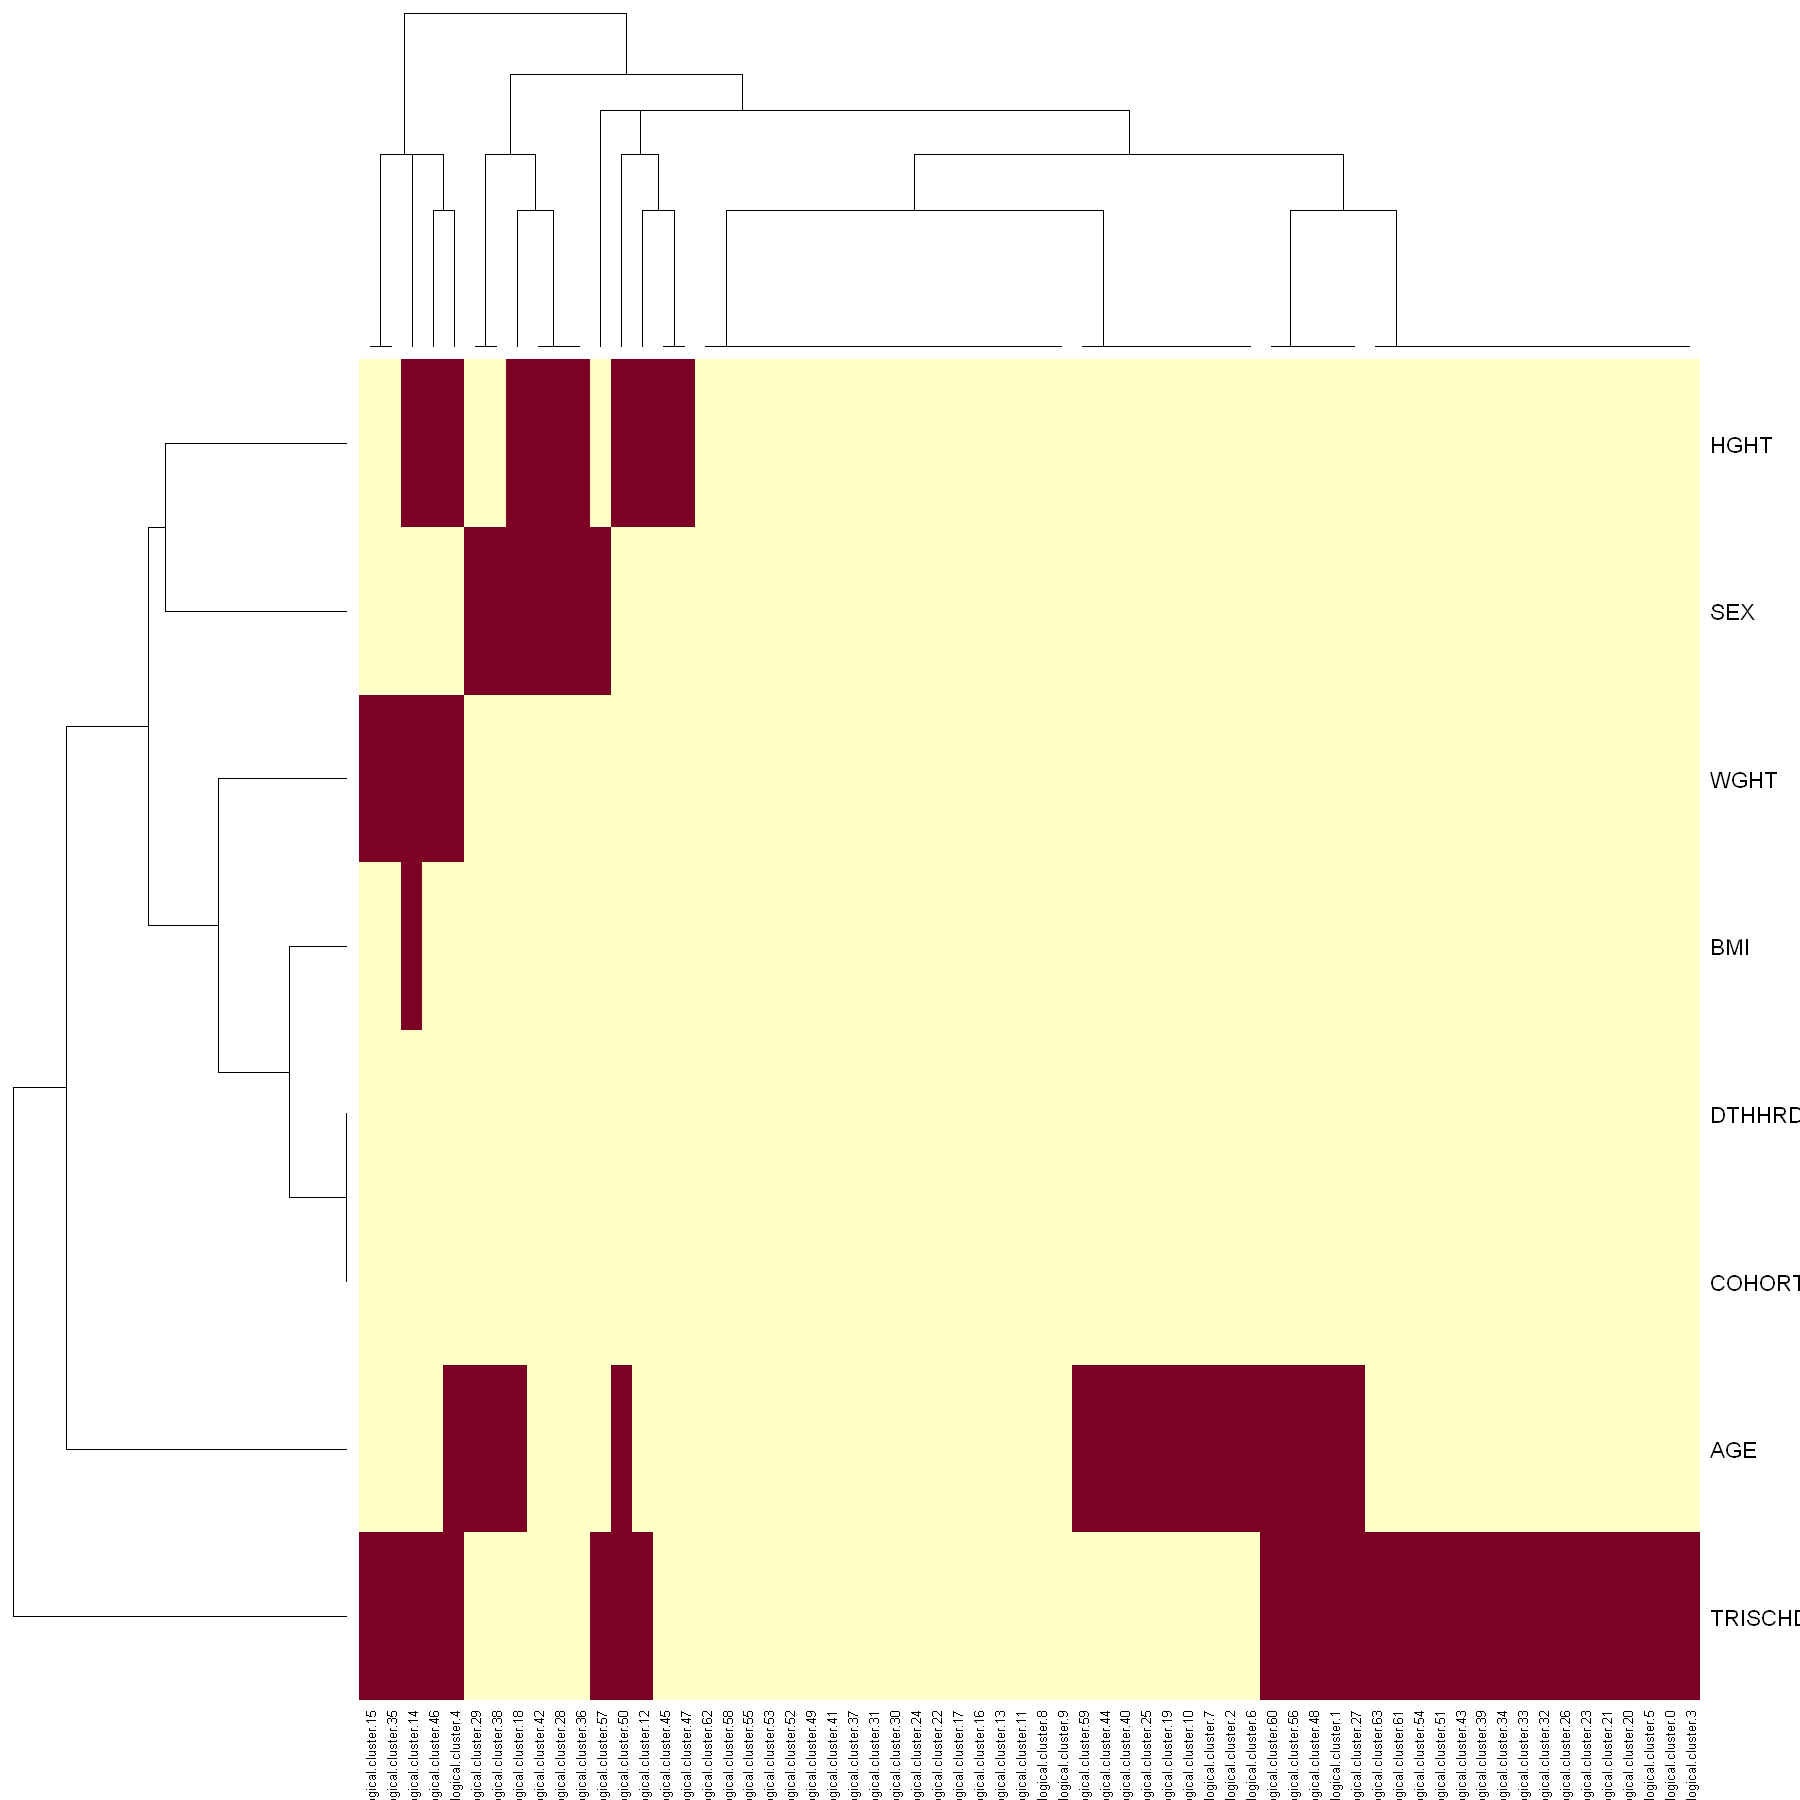

In [73]:
options(repr.plot.width=15, repr.plot.height=15)
heatmap(data.matrix(assoc_table), scale='none')

#### Age

In [ ]:
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~AGE)


In [ ]:
dds <- DESeq(dds)
res <- results(dds)
resultsNames(dds)
res
summary(res)

In [ ]:
res.05 <- results(dds, alpha = 0.05)
table(res.05$padj < 0.05)
resSig <- subset(res, padj < 0.05)
resSig[ order(resSig$log2FoldChange), ]
assoc_table[2,] <- colnames(assoc_table) %in% rownames(resSig)
assoc_table